# **Maestría en Inteligencia Artificial Aplicada**

## **Inteligencia Artificial y Aprendizaje Automático**

### Tecnológico de Monterrey

### Prof Luis Eduardo Falcón Morales

## **Modelos sobre datos de Series de Tiempo - Parte 2: LSTM**


#### **Los diferentes modelos que aplicamos en este ejercicio son utilizando la base de datos que nos muestran el total de pasajeros mensuales que viajaron en una aerolínea de EEUU de 1949 a 1960.**

#### **La liga de los datos la puedes encontrar en la siguiente liga de Kaggle:**

https://www.kaggle.com/datasets/chirag19/air-passengers



# **4 - Long Short Term Memory (LSTM)**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
import keras
from keras import Sequential
from keras import layers
from keras.layers import LSTM, Dense

In [ ]:
path = 'airline-passengers.csv'
df = pd.read_csv(path, header=0)

df.columns = ['ds', 'y']
df['ds']= pd.to_datetime(df['ds'])

df_temp = df.copy()
df_temp.set_index('ds', inplace=True)
df_temp.index.freq = 'MS'


In [ ]:
df_temp.head(3)   # vemos que la serie inicia en enero 1949

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132


In [ ]:
df_temp.tail(3)   # y termina en diciembre de 1960.

,y
ds,
1960-10-01,461
1960-11-01,390
1960-12-01,432


In [ ]:
# Definimos una función para crear secuencias de tiempo
# con la ventada de tiempo que consideremos adecuada.

def creamos_secuencias(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])  # Ventana en este ejercicio de 12 meses de manera continua
        y.append(data[i])  # y el siguiente mes a predecir, dados los 12 anteriores.
    return np.array(X), np.array(y)

In [ ]:
# Tamaño de la ventana, para este ejercicio de la aerolínea estamos
# considerando 12 meses:

window_size = 12

# Creamos las secuencias de entrenamiento
X, y = creamos_secuencias(df_temp[['y']].values, window_size)

print(X.shape)  # verifiquemos que el formato es el requerido por la CNN.

(132, 12, 1)


In [ ]:
# Si no tiene el formato LSTM puedes hacerlo como sigue:
# El formato debe ser un vector de 3 dimensiones:
#       (número_de_secuencias, tamaño_de_cada_secuencia, número_de_variables)

#X = X.reshape((X.shape[0], X.shape[1], 1))

In [ ]:
# Dividimos los datos en Entrenamiento y Prueba:
split = int(0.85 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(X_train.shape)   # (secuencias, tamaño_secuencia, variables)
print(X_test.shape)    # Test no necesariamente tiene que ser de 12 secuencias, pero sí al menos incluir 12.

(112, 12, 1)
(20, 12, 1)


# Puedes consultar la documentación para los argumentos de la LSTM:

https://keras.io/api/layers/recurrent_layers/lstm/

In [ ]:
# Construimos un modelo secuencial relativamente simple basado en LSTMs:
model = Sequential()
model.add(LSTM(50,  # total de neuronas de la capa LSTM
               return_sequences=True, # para que siga manteniendo el formato de 3 dimensiones.
               activation='relu',
               recurrent_activation='sigmoid'
               ))  # Capa LSTM
model.add(LSTM(50, return_sequences=False, activation='relu'))
model.add(Dense(1))  # Capa de salida

# Compilamos el modelo
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.RootMeanSquaredError()],   #  despliega RMSE
              )

# y llevamos a cabo el entrenamiento con los cunjuntos de entrenamiento y prueba:
history = model.fit(X_train, y_train, epochs=65, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/65
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - loss: 46941.6094 - root_mean_squared_error: 215.9963 - val_loss: 46563.2031 - val_root_mean_squared_error: 215.7851
Epoch 2/65
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8409.1787 - root_mean_squared_error: 91.0191 - val_loss: 10171.7812 - val_root_mean_squared_error: 100.8552
Epoch 3/65
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 6080.4780 - root_mean_squared_error: 77.5365 - val_loss: 11637.8770 - val_root_mean_squared_error: 107.8790
Epoch 4/65
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2132.3760 - root_mean_squared_error: 46.1548 - val_loss: 9057.8281 - val_root_mean_squared_error: 95.1726
Epoch 5/65
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1901.9857 - root_mean_squared_error: 43.5871 - val_loss: 4034.4304 - val_root_mean_squared_error: 63.5172
Epoch 6/65
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1248.9534 - root_mean_squared_error: 35.3224 - val_loss: 3897.5442 - val_root_mean_squared_error: 62.4303
Epoch 7/65
4/

In [ ]:
# hacemos la predicción para los últimos 12 meses solamente, para poder
# compararlo con los modelos que obtuvimos previamente, a saber, el ingenuo,
# arima y prophet:

pred_LSTM = model.predict(X_test[-12:])
y_test_real = y_test[-12:].reshape(-1, 1)

# Calculamos el RMSE en la escala original de los datos:
rmse = np.sqrt(mean_squared_error(y_test_real, pred_LSTM))
print('\nError-Modelo-FacebookProphet: RMSE: %.3f' % rmse)    # recuerda que los resultados que obtengas pueden ser
                                                              # algo diferentes cada vez que lo vuelves a entrenar.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step

Error-Modelo-FacebookProphet: RMSE: 17.208


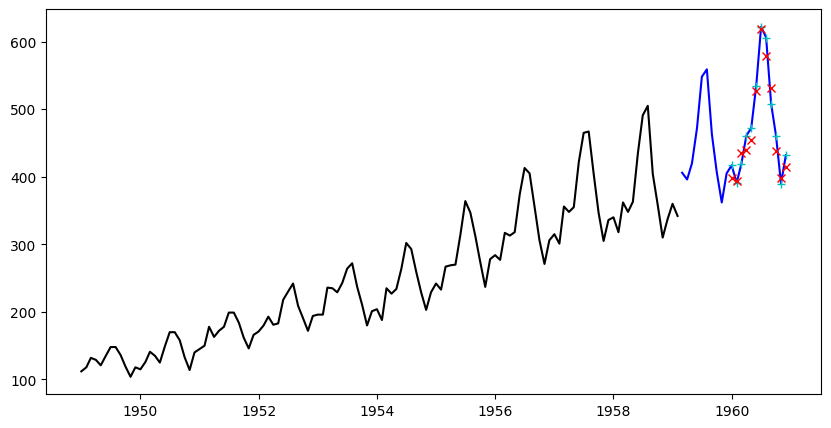

In [ ]:
# Grafiquemos los resultados:

fig, ax = plt.subplots(figsize=(10, 5))
ax = plt.plot(df['ds'][0:int(0.85 * len(df))], df['y'][0:int(0.85 * len(df))], '-k')  # Datos de entrenamiento de 1949 a 1959.
ax = plt.plot(df['ds'][int(0.85 * len(df)):], df['y'][int(0.85 * len(df)):], '-b')    # Datos de prueba del año 1960 y un poco mas, dependiendo del tamaño de Test.
ax = plt.plot(df['ds'][-12:], df['y'][-12:], '+c')    # Datos de prueba incluyendo solo los puntuales reales del año 1960.
ax = plt.plot(df['ds'][-12:], pred_LSTM, 'xr')  # Predicciones puntuales del modelo del último año 1960.

>> ## **Fin del Ejercicio de Series de Tiempo - Parte 2**